In [40]:
import pickle
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [41]:
model_path='../models/bn_trained_final.pkl',

with open('../models/bn_trained_final.pkl', 'rb') as f:
    model = pickle.load(f)

print(f"Model loaded from: {model_path}")
print(f"Nodes: {list(model.nodes())}")
print(f"Edges: {list(model.edges())}")

df_balanced = pd.read_csv('../data/processed/data_discretized_final.csv')

print(f"Data loaded: {df_balanced.shape}")


target = 'fms'


Model loaded from: ('../models/bn_trained_final.pkl',)
Nodes: ['Motion_Intensity', 'Left_Diameter', 'GSR', 'fms', 'Right_Diameter']
Edges: [('Motion_Intensity', 'Left_Diameter'), ('Left_Diameter', 'Right_Diameter'), ('Left_Diameter', 'fms'), ('Left_Diameter', 'GSR'), ('GSR', 'fms'), ('GSR', 'Right_Diameter'), ('Right_Diameter', 'fms')]
Data loaded: (30240, 11)


In [42]:
for cpd in model.get_cpds():
    print(f"{cpd.variable}: {cpd.state_names[cpd.variable]}")

Motion_Intensity: [1, 2, 3, 4, 5]
Left_Diameter: [1, 2, 3, 4, 5]
GSR: [1, 2, 3, 4, 5]
fms: [1, 2, 3, 4, 5, 6, 7]
Right_Diameter: [1, 2, 3, 4, 5]


In [43]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inference = VariableElimination(model)

model_nodes = set(model.nodes())
evidence_nodes = [n for n in model_nodes if n != target]

print(f"Model nodes: {list(model_nodes)}")
print(f"Evidence nodes for inference: {evidence_nodes}")

X = df_balanced[evidence_nodes]
y = df_balanced[target]

results = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), 1):
    
    y_pred = []
    y_true = y.iloc[test_idx].values
    
    for idx in test_idx:
        # Only include evidence for nodes that exist in model
        evidence = {col: df_balanced.iloc[idx][col] for col in evidence_nodes}
        
        result = inference.query(variables=[target], evidence=evidence, show_progress=False)
        pred = result.state_names[target][np.argmax(result.values)]
        y_pred.append(pred)
    
    y_pred = np.array(y_pred)
    
    # Calculate metrics
    exact_acc = accuracy_score(y_true, y_pred)
    extended = np.mean(np.abs(y_true - y_pred) <= 1)
    
    results.append({
        'fold': fold,
        'exact_accuracy': exact_acc,
        'extended_accuracy': extended,
        'y_true': y_true,
        'y_pred': y_pred
    })
    
    print(f"  Exact: {exact_acc:.2%}, Extended (±1): {extended:.2%}")

results_df = pd.DataFrame([{
    'fold': r['fold'],
    'exact_accuracy': r['exact_accuracy'],
    'extended_accuracy': r['extended_accuracy']
} for r in results])


Model nodes: ['Left_Diameter', 'GSR', 'fms', 'Motion_Intensity', 'Right_Diameter']
Evidence nodes for inference: ['Left_Diameter', 'GSR', 'Motion_Intensity', 'Right_Diameter']
  Exact: 63.13%, Extended (±1): 76.41%
  Exact: 62.88%, Extended (±1): 76.36%
  Exact: 63.05%, Extended (±1): 76.09%
  Exact: 62.62%, Extended (±1): 76.06%
  Exact: 63.11%, Extended (±1): 76.52%


In [44]:
results_df = pd.DataFrame(results)
print("="*60)
print("CROSS-VALIDATION RESULTS")
print("="*60)
print(results_df[['fold', 'exact_accuracy', 'extended_accuracy']])
print(f"\nAverage Exact Accuracy: {results_df['exact_accuracy'].mean():.2%}")
print(f"Average Extended Accuracy: {results_df['extended_accuracy'].mean():.2%}")
print("="*60)

CROSS-VALIDATION RESULTS
   fold  exact_accuracy  extended_accuracy
0     1        0.631283           0.764054
1     2        0.628803           0.763558
2     3        0.630456           0.760913
3     4        0.626157           0.760582
4     5        0.631118           0.765212

Average Exact Accuracy: 62.96%
Average Extended Accuracy: 76.29%


In [45]:
print("\n" + "="*60)
print("Comparison with Baseline")
print("="*60)

wu_exact = 0.6212
wu_extended = 0.8355

our_exact = results_df['exact_accuracy'].mean()
our_extended = results_df['extended_accuracy'].mean()

comparison = pd.DataFrame({
    'Metric': ['Exact Accuracy', 'Extended Accuracy (±1)'],
    'Wu et al. 2025': [f'{wu_exact:.2%}', f'{wu_extended:.2%}'],
    'Our Implementation': [f'{our_exact:.2%}', f'{our_extended:.2%}'],
    'Delta': [f'{our_exact-wu_exact:+.2%}', f'{our_extended-wu_extended:+.2%}']
})

print(comparison.to_string(index=False))


Comparison with Baseline
                Metric Wu et al. 2025 Our Implementation  Delta
        Exact Accuracy         62.12%             62.96% +0.84%
Extended Accuracy (±1)         83.55%             76.29% -7.26%


Saved: ../data/results/confusion_matrices_fold1.png


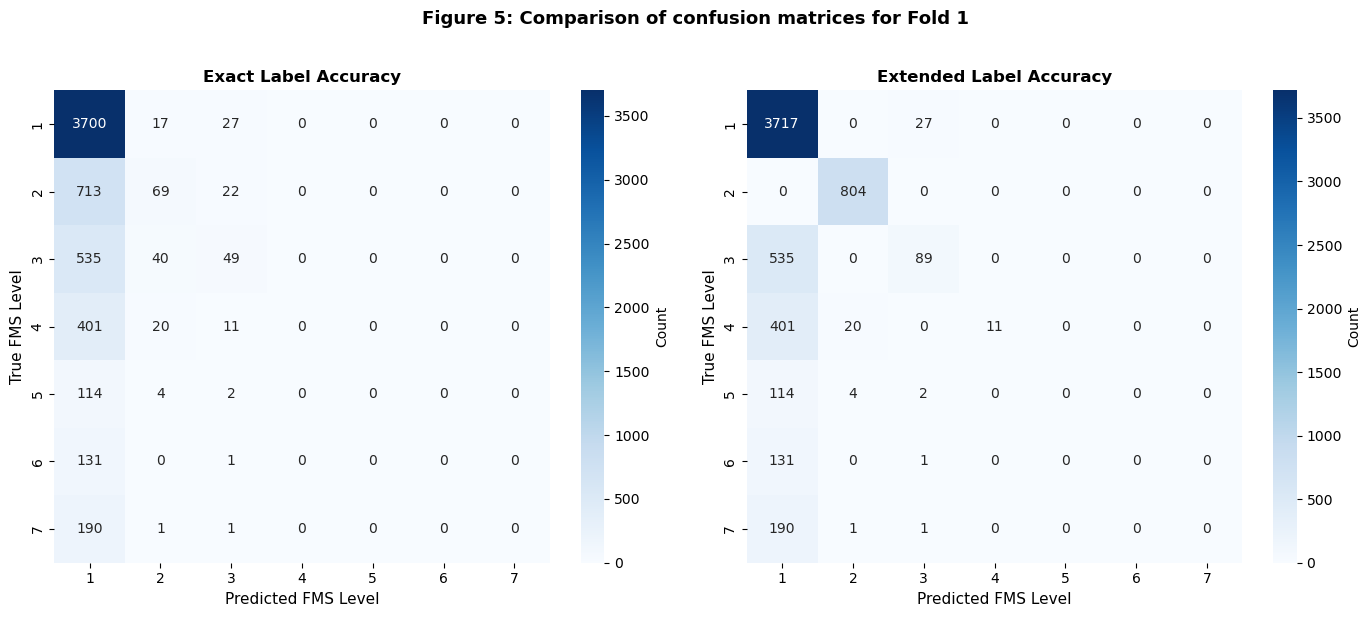

Saved: ../data/results/confusion_matrices_fold2.png


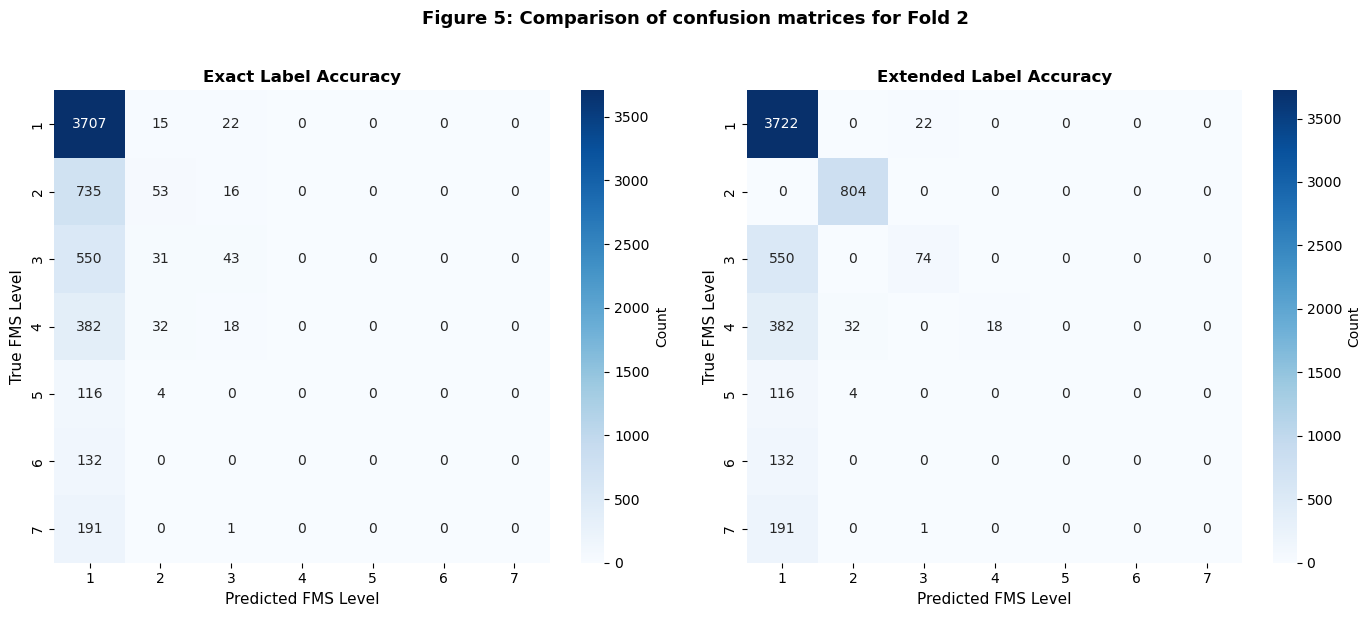

Saved: ../data/results/confusion_matrices_fold3.png


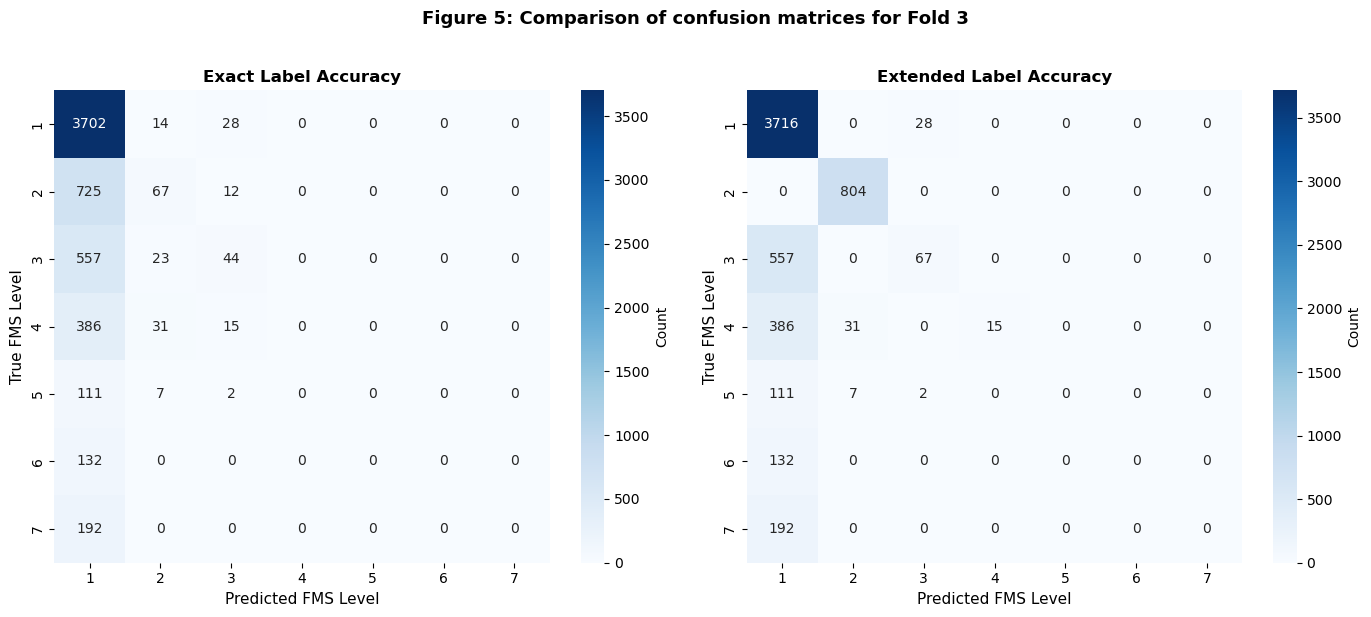

Saved: ../data/results/confusion_matrices_fold4.png


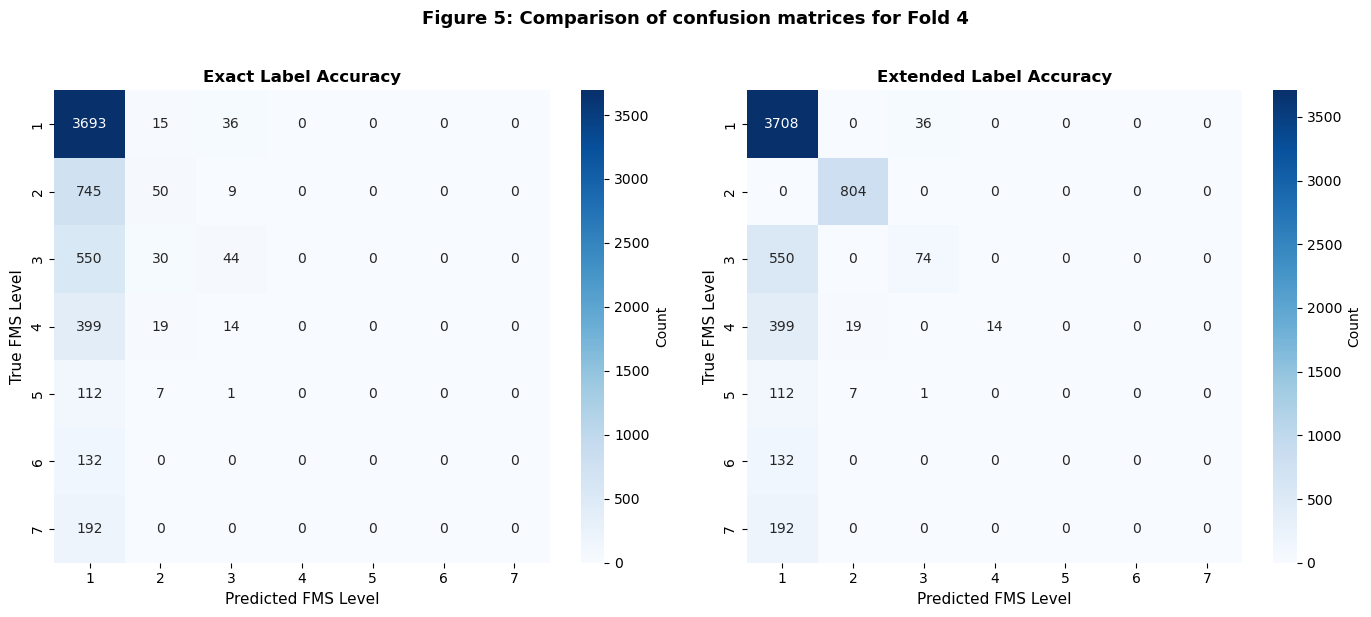

Saved: ../data/results/confusion_matrices_fold5.png


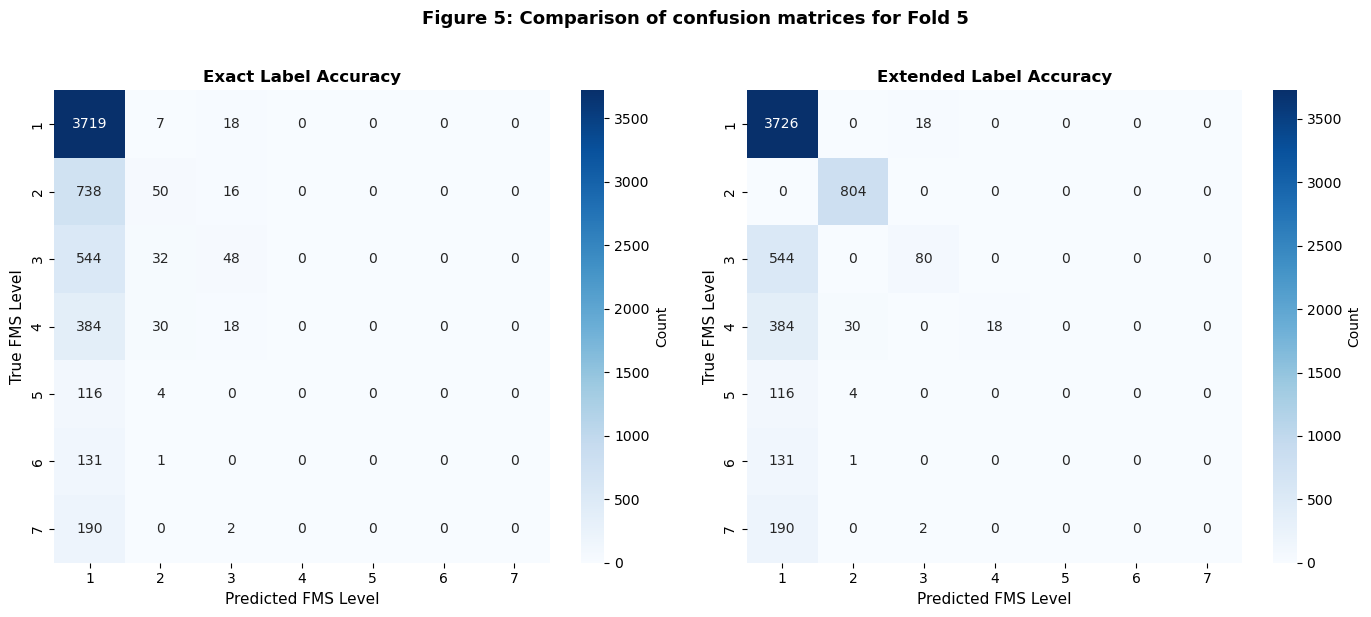

In [46]:
def plot_dual_confusion_matrix(fold_results, fold_num, save_dir='../data/results'):
    y_true = fold_results['y_true']
    y_pred_exact = fold_results['y_pred']
    
    # Generate extended predictions (count within ±1 as correct)
    y_pred_extended = []
    for true, pred in zip(y_true, y_pred_exact):
       if abs(true - pred) <= 1:
           y_pred_extended.append(true)  # Map to TRUE value (diagonal)
       else:
          y_pred_extended.append(pred)  # Keep wrong prediction
    y_pred_extended = np.array(y_pred_extended)
    
    # Create confusion matrices
    labels = [1, 2, 3, 4, 5, 6, 7]
    cm_exact = confusion_matrix(y_true, y_pred_exact, labels=labels)
    cm_extended = confusion_matrix(y_true, y_pred_extended, labels=labels)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Exact accuracy
    sns.heatmap(cm_exact, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'}, ax=axes[0])
    axes[0].set_xlabel('Predicted FMS Level', fontsize=11)
    axes[0].set_ylabel('True FMS Level', fontsize=11)
    axes[0].set_title('Exact Label Accuracy', fontsize=12, fontweight='bold')
    
    # Extended accuracy
    sns.heatmap(cm_extended, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'}, ax=axes[1])
    axes[1].set_xlabel('Predicted FMS Level', fontsize=11)
    axes[1].set_ylabel('True FMS Level', fontsize=11)
    axes[1].set_title('Extended Label Accuracy', fontsize=12, fontweight='bold')
    
    # Overall title
    fig.suptitle(f'Figure 5: Comparison of confusion matrices for Fold {fold_num}',
                 fontsize=13, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Save
    save_path = f'{save_dir}/confusion_matrices_fold{fold_num}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    
    plt.show()
    
    return cm_exact, cm_extended


# Plot for each fold
for fold_data in results:
    plot_dual_confusion_matrix(fold_data, fold_data['fold'])
